# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): AC209

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


In [3]:
x_train = data_train[["Biomarker 1", "Biomarker 2"]].reset_index(drop=True)
y_train = data_train["Diagnosis"].reset_index(drop=True)

x_test = data_test[["Biomarker 1", "Biomarker 2"]].reset_index(drop=True)
y_test = data_test["Diagnosis"].reset_index(drop=True)

x_train.head()

,Biomarker 1,Biomarker 2
0,0.262372,0.875473
1,0.336479,1.098616
2,0.182330,-1.609488
3,-0.223131,0.788462
4,0.587792,1.458617


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Part 1 ####

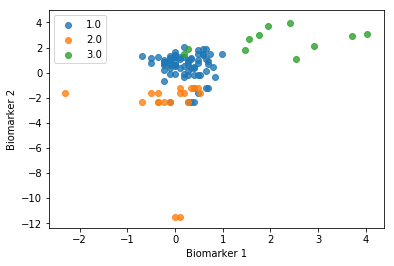

In [4]:
diag_groups = data_train.groupby('Diagnosis')

for name, group in diag_groups:
    plt.scatter(group['Biomarker 1'], group['Biomarker 2'], label=name, alpha=0.8)

plt.legend(loc='best')
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.show()

The data points do appear classifiable by linear classifier (most of the points are well seperated)

#### Part 2 ####

The OvR logistic regression assume each class's prediction is independent from other classes, thus making a multiple class regression problem into a multiple binary classification problem.

On the other hand, multinomial logistic regression takes all the classes into consideration during fitting.

#### Part 3 ####

In [5]:
OVR = LogisticRegressionCV(Cs=10, cv=3, penalty="l2", multi_class="ovr", random_state=9001)
OVR.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=9001,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [6]:
y_train_pred_ovr = OVR.predict(x_train)
pd.crosstab(y_train,y_train_pred_ovr,margins=True,dropna=False,
            rownames=["y_train"], colnames=["y_train_pred_ovr"])

y_train_pred_ovr,1.0,2.0,3.0,All
y_train,,,,
1.0,69,4,0,73
2.0,9,9,0,18
3.0,3,0,8,11
All,81,13,8,102


In [7]:
print("One-vs-Rest train set accuracy: ", OVR.score(x_train, y_train))
print("One-vs-Rest test set accuracy: ", OVR.score(x_test, y_test))

One-vs-Rest train set accuracy:  0.843137254902
One-vs-Rest test set accuracy:  0.840707964602


In [8]:
MLR = LogisticRegressionCV(Cs=10, cv=3, penalty="l2", multi_class="multinomial", random_state=9001)
MLR.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=9001, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [9]:
y_train_pred_mlr = MLR.predict(x_train)
pd.crosstab(y_train,y_train_pred_mlr,margins=True,dropna=False,
            rownames=["y_train"], colnames=["y_train_pred_mlr"])

y_train_pred_mlr,1.0,2.0,3.0,All
y_train,,,,
1.0,69,4,0,73
2.0,5,13,0,18
3.0,2,0,9,11
All,76,17,9,102


In [10]:
print("Multinomial train set accuracy: ", MLR.score(x_train, y_train))
print("Multinomial test set accuracy: ", MLR.score(x_test, y_test))

Multinomial train set accuracy:  0.892156862745
Multinomial test set accuracy:  0.884955752212


Multinominal logistic regression performs a bit better here. We see from the confusion table that the better performance originates from more accurate classification of class 2.

#### Part 4 ####

In [11]:
x_train_poly = PolynomialFeatures(degree=2).fit_transform(x_train)
x_test_poly = PolynomialFeatures(degree=2).fit_transform(x_test)

MLR_poly = LogisticRegressionCV(Cs=10, cv=3, penalty="l2", multi_class="multinomial", random_state=9001)
MLR_poly.fit(x_train_poly, y_train)

y_train_poly = MLR_poly.predict(x_train_poly)
print("Multiclass Logistic Regression with quadratic terms train set accuracy: ", MLR_poly.score(x_train_poly, y_train))
print("Multiclass Logistic Regression with quadratic terms test set accuracy: ", MLR_poly.score(x_test_poly, y_test))

Multiclass Logistic Regression with quadratic terms train set accuracy:  0.892156862745
Multiclass Logistic Regression with quadratic terms test set accuracy:  0.893805309735


In [12]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train, y_train)

y_train_train_LDA = LDA.predict(x_train)
print("Linear Discriminant Analysis train set accuracy: ", LDA.score(x_train, y_train))
print("Linear Discriminant Analysis test set accuracy: ", LDA.score(x_test, y_test))

Linear Discriminant Analysis train set accuracy:  0.872549019608
Linear Discriminant Analysis test set accuracy:  0.83185840708


In [13]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(x_train, y_train)

y_train_QDA = QDA.predict(x_train)
print("Quadratic Discriminant Analysis train set accuracy: ", QDA.score(x_train, y_train))
print("Quadratic Discriminant Analysis test set accuracy: ", QDA.score(x_test, y_test))

Quadratic Discriminant Analysis train set accuracy:  0.872549019608
Quadratic Discriminant Analysis test set accuracy:  0.849557522124


In [14]:
knn_scores = []
n_max = 26
for n in range(1, n_max):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn_scores.append(cross_val_score(knn, x_train, y_train, cv=3).mean())

knn_scores = np.array(knn_scores)

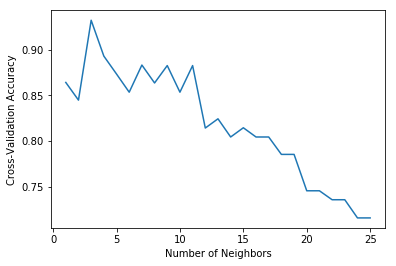

In [15]:
plt.plot(np.arange(1, n_max, 1), knn_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

In [16]:
best_n = knn_scores.argmax()
knn_best = KNeighborsClassifier(n_neighbors=best_n)
knn_best.fit(x_train, y_train)

y_train_knn = knn_best.predict(x_train)
print("k-Nearest Neighbors (n=%d) train set accuracy: %.5f" % 
      (best_n, knn_best.score(x_train, y_train)))
print("k-Nearest Neighbors (n=%d) test set accuracy: %.5f" % 
      (best_n, knn_best.score(x_test, y_test)))

k-Nearest Neighbors (n=2) train set accuracy: 0.90196
k-Nearest Neighbors (n=2) test set accuracy: 0.84956


#### Part 5 ####

For the training set their performance are identical, while for the testing set the inclusion of quadratic term improved the accuracy by roughly 1%.

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [17]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

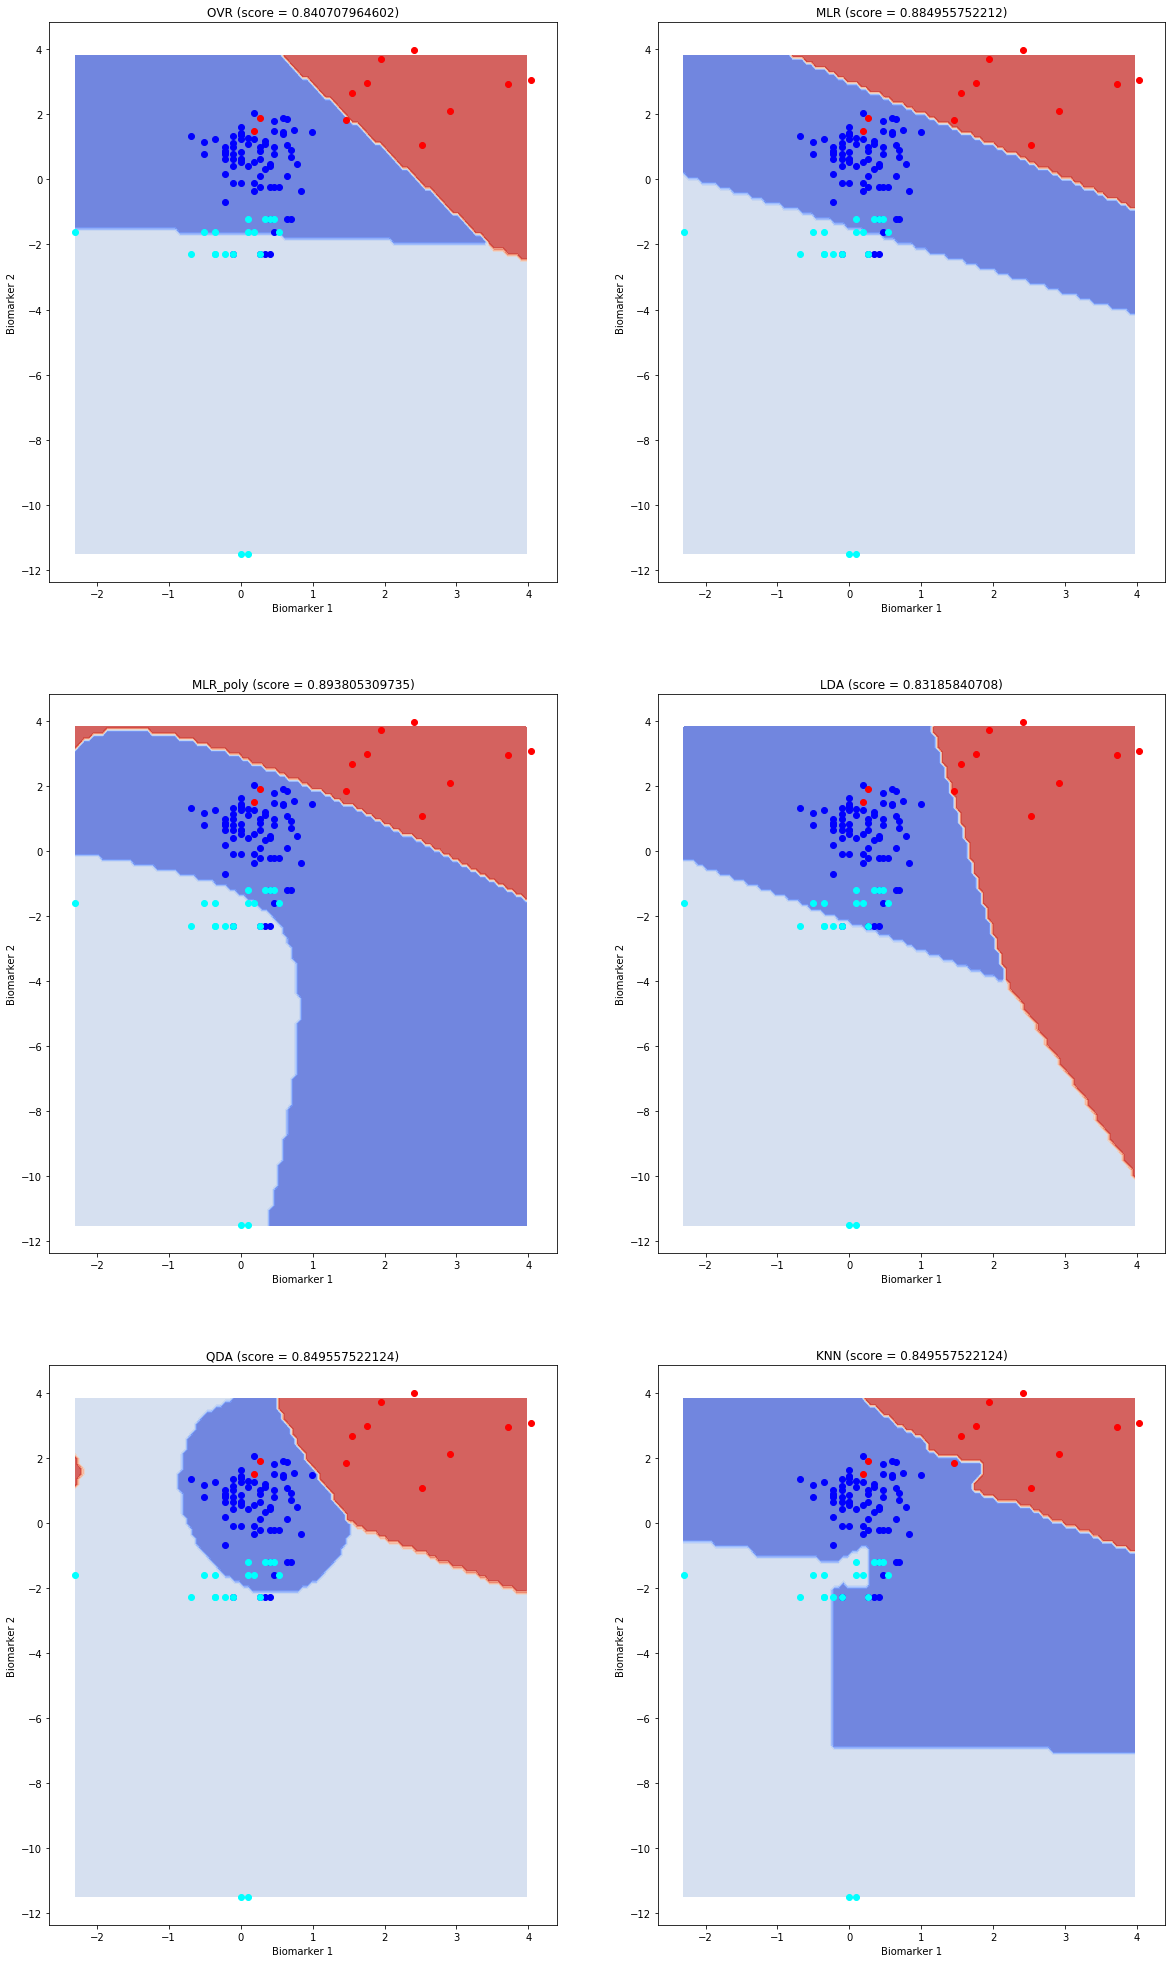

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(20, 35))

# one-vs-rest (OVR)
acc_OVR = OVR.score(x_test, y_test)
str_title = 'OVR (score = ' + str(acc_OVR) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), OVR, str_title, ax[0][0] )

# multinominal logistic regression (MLR)
acc_MLR = MLR.score(x_test, y_test)
str_title = 'MLR (score = ' + str(acc_MLR) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), MLR, str_title, ax[0][1] )

# MLR with polynomial features
acc_MLR_poly = MLR_poly.score(x_test_poly, y_test)
str_title = 'MLR_poly (score = ' + str(acc_MLR_poly) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), MLR_poly, str_title, ax[1][0],\
                                 poly_degree=2)

# LDA
acc_lda = LDA.score(x_test, y_test)
str_title = 'LDA (score = ' + str(acc_lda) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), LDA, str_title, ax[1][1] )

# QDA
acc_qda = QDA.score(x_test, y_test)
str_title = 'QDA (score = ' + str(acc_qda) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), QDA, str_title, ax[2][0] )

# KNN
acc_knn = knn_best.score(x_test, y_test)
str_title = 'KNN (score = ' + str(acc_knn) + ')'
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), knn_best, str_title, ax[2][1] )

OvR vs Multinomial:
> The boundaries of Multinomial logistic regression (w/o polynomial term) are straight lines whereas the OVR can have corners.

Linear Logistic vs LDA
> The boundaries of LDA are somewhat similar to OvR where corner can exist, whereas the linear logistic model gives straight line boundary.

Quadratic Logistic vs QDA
> The boundaries of Quadratic Logistic are parabolic function while QDA can have closed boundaries.

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

#### Q3 Part 1 ####

In [19]:
max_depth = 11
tree_scores_train = []
tree_scores_test = []

for d in range(2, max_depth):
    DT = DecisionTreeClassifier(max_depth=d)
    DT.fit(x_train, y_train)
    tree_scores_train.append(DT.score(x_train, y_train))
    tree_scores_test.append(DT.score(x_test, y_test))

tree_scores_train = np.array(tree_scores_train)
tree_scores_test = np.array(tree_scores_test)
tree_scores_train.max()

0.97058823529411764

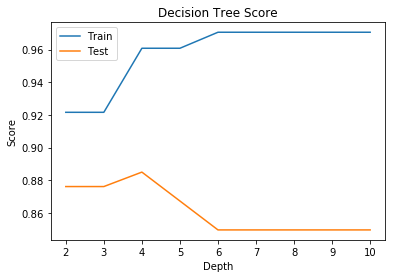

In [20]:
plt.plot(np.arange(2, max_depth, 1), tree_scores_train, label='Train')
plt.plot(np.arange(2, max_depth, 1), tree_scores_test, label='Test')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Decision Tree Score')
plt.legend(loc='best')
plt.show()

At depth >= 6, the training accuracy reachs the maximum value 0.97, an almost perfect value. However, in such cases, the model inevitably overfit the training data, and thus the testing data accuracy would be lower.

#### Q3 Part 2 ####

In [21]:
max_depth = 11
tree_cv_scores_train = []
tree_cv_scores_test = []

for d in range(2, max_depth):
    DT = DecisionTreeClassifier(max_depth=d)
    tree_cv_scores_train.append(cross_val_score(cv=5, estimator=DT, X=x_train, y=y_train).mean())
    tree_cv_scores_test.append(cross_val_score(cv=5, estimator=DT, X=x_test, y=y_test).mean())
    
tree_cv_scores_train = np.array(tree_cv_scores_train)
tree_cv_scores_test = np.array(tree_cv_scores_test)

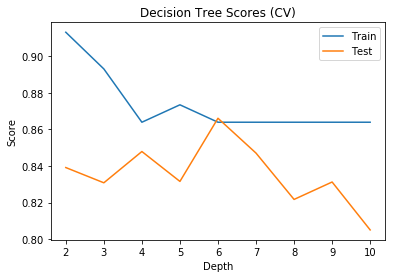

In [22]:
plt.plot(np.arange(2, max_depth, 1), tree_cv_scores_train, label='Train')
plt.plot(np.arange(2, max_depth, 1), tree_cv_scores_test, label='Test')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Decision Tree Scores (CV)')
plt.legend(loc='best')
plt.show()

In [23]:
best_ind = tree_cv_scores_train.argmax()
best_depth = best_ind + 2 # Start with depth = 2
print('Best Decision Tree Depth: %d' % best_depth)
print('Best Decision Tree Training Score: %.5f' % tree_cv_scores_train[best_ind])
print('Best Decision Tree Testing Score: %.5f' % tree_cv_scores_test[best_ind])

Best Decision Tree Depth: 2
Best Decision Tree Training Score: 0.91315
Best Decision Tree Testing Score: 0.83918


The performance of the decision tree model using cross-validation is similar but worse than the multinomial, OvR and knn model, but slightly better than the LDA and QDA model.

#### Q3 Part 3 ####

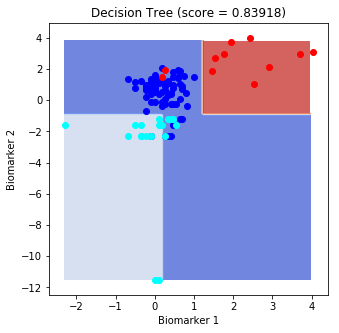

In [24]:
DT = DecisionTreeClassifier(max_depth=best_depth)
DT.fit(x_train, y_train)

title = 'Decision Tree (score = %.5f)' % tree_cv_scores_test[best_ind]

fig, ax = plt.subplots(figsize=(5, 5))
plot_decision_boundary(x_train.as_matrix(), y_train.as_matrix(), DT, title, ax)

The boundaries of decision tree model seperate the feature space (plane here) in to multiple retangular blocks in such a way that each line in the boundary is orthogonal to one of the feature axis.

In [25]:
# Have to install pydotplus and graphviz packages

from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()
export_graphviz(DT, out_file=dot_data, feature_names=df.columns.values,\
                filled=True, rounded=True, special_characters=True, )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

#### Q4 Part 1 ####

In [ ]:
Model_Scores = pd.DataFrame({'Training Score': 
              [OVR.score(x_train, y_train),
               MLR.score(x_train, y_train),
               MLR_poly.score(x_train_poly, y_train),
               LDA.score(x_train, y_train),
               QDA.score(x_train, y_train),
               knn_best.score(x_train, y_train),
               DT.score(x_train, y_train)],
              'Testing Score':
             [OVR.score(x_test, y_test),
               MLR.score(x_test, y_test),
               MLR_poly.score(x_test_poly, y_test),
               LDA.score(x_test, y_test),
               QDA.score(x_test, y_test),
               knn_best.score(x_test, y_test),
               DT.score(x_test, y_test)]}, 
             index=['OvR', 'MLR', 'MLR_Poly', 'LDA', 'QDA', 'knn', 'DT'])

Model_Scores

- Classification performance
> MLR_Poly > MLR > Decision Tree > QDA = KNN > OvR > LDA

- Complexity of decision boundary
> From least complicated to the most:
MLR > LDA = OvR > Decision Tree > MLR_Poly > QDA > KNN

- Memory storage
> From least memory used to most:
LDA > QDA > MLR > OvR > MLR_Poly > Decision Tree > KNN

- Ease of interpretability
> Decision Tree > MLR = OvR = LDA > MLR_Poly = QDA > KNN

#### Q4 Part 2 ####

The decision tree method will be the easiest to use as it can be interpreted as a step-by-step True/False method, even though it gives a moderate accuracy. My second option will by Multinomial Logistic Regress for its high accuracy.

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [94]:
y_train_ovr = OVR.predict(x_train)
y_test_ovr = OVR.predict(x_test)

train_table = pd.crosstab(y_train,y_train_ovr,margins=True,dropna=False, rownames=["y_train"], colnames=["y_train_ovr"])
test_table = pd.crosstab(y_test,y_test_ovr,margins=True,dropna=False, rownames=["y_test"], colnames=["y_test_ovr"])

In [28]:
train_table

y_train_ovr,1.0,2.0,3.0,All
y_train,,,,
1.0,69,4,0,73
2.0,9,9,0,18
3.0,3,0,8,11
All,81,13,8,102


In [29]:
test_table

y_test_ovr,1.0,2.0,3.0,All
y_train,,,,
1.0,74,3,0,77
2.0,11,6,0,17
3.0,4,0,15,19
All,89,9,15,113


In [32]:
y_train_prob = OVR.predict_proba(x_train)
prob_df = pd.DataFrame(y_train_prob, columns=['1', '2', '3'])
prob_df.head() # The probability for each sample point to be classified as all three classes

,1,2,3
0,0.961119,0.012946,0.025935
1,0.947009,0.007771,0.045221
2,0.527879,0.472003,0.000118
3,0.965960,0.026040,0.008000
4,0.867326,0.002763,0.129911


In [37]:
prob_df['actual'] = y_train.astype(int)
prob_df['prediction'] = y_train_ovr.astype(int)
prob_df.head()

,1,2,3,actual,prediction
0,0.961119,0.012946,0.025935,1,1
1,0.947009,0.007771,0.045221,1,1
2,0.527879,0.472003,0.000118,2,1
3,0.965960,0.026040,0.008000,1,1
4,0.867326,0.002763,0.129911,1,1


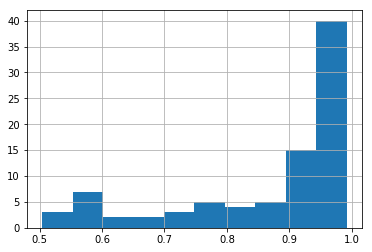

In [48]:
# Plot a histogram of the probabilities where the prediction are correct
prob_df[prob_df['actual']==prob_df['prediction']].apply(lambda p: p[str(int(p['actual']))], axis=1).hist()
plt.show()

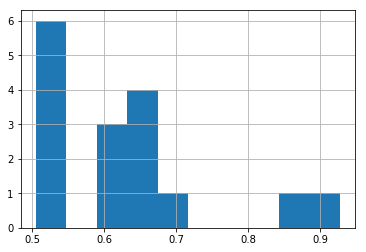

In [62]:
# Plot a histogram of the probabilities where the prediction are wrong
prob_df[prob_df['actual']!=prob_df['prediction']].apply(lambda p: p[str(int(p['prediction']))], axis=1).hist()
plt.show()

From the histograms above we can see that misdiagnosis are more likely to happen when the prediction probability is low (0.5-0.7). So to minimize the average cost per patient, we can find a threshold on the probability below which the model will just abstain to predict.

In [112]:
# Calculate costs at different threshold level
thresholds = np.arange(0.5, 1, 0.01)
prob_max = y_train_prob.max(axis=1)
cost_misdiagnosis=[]
cost_abstain=[]
for th in thresholds:    
    below_th_ind = np.where(prob_max < th)[0]
    above_th_ind = np.where(prob_max >= th)[0]
    
    cost_misdiagnosis.append((y_train_ovr[above_th_ind] != y_train[above_th_ind]).sum()*5000)
    cost_abstain.append(len(below_th_ind)*1000)
    
cost_misdiagnosis = np.array(cost_misdiagnosis)/len(y_train)
cost_abstain = np.array(cost_abstain)/len(y_train)
cost_total = cost_misdiagnosis + cost_abstain

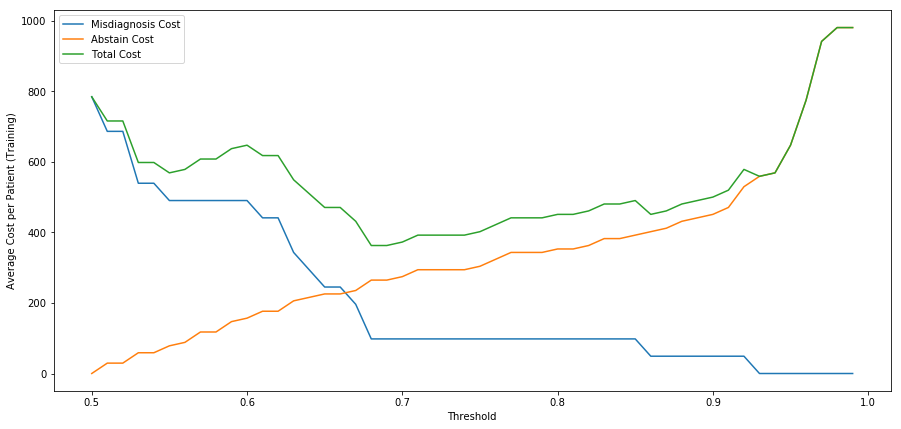

In [115]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(thresholds, cost_misdiagnosis, label='Misdiagnosis Cost')
plt.plot(thresholds, cost_abstain, label='Abstain Cost')
plt.plot(thresholds, cost_total, label='Total Cost')
plt.xlabel('Threshold')
plt.ylabel('Average Cost per Patient (Training)')
plt.legend(loc='best')
plt.show()

In [118]:
th_best = thresholds[cost_total.argmin()]
print('The minimum average cost is $%.2f per patient when threshold is set to be %.2f (Training set)' % 
     (cost_total.min(), th_best))

The minimum average cost is $362.75 per patient when threshold is set to be 0.68 (Training set)


In [121]:
# Calculate average cost on the testing set
y_test_prob = OVR.predict_proba(x_test)
prob_max_test = y_test_prob.max(axis=1)

below_th_ind = np.where(prob_max_test < th_best)[0]
above_th_ind = np.where(prob_max_test >= th_best)[0]

cost_misdiagnosis_test = ((y_test_ovr[above_th_ind] != y_test[above_th_ind]).sum()*5000)/len(y_test)
cost_abstain_test = len(below_th_ind)*1000/len(y_test)
cost_total_test = cost_misdiagnosis_test + cost_abstain_test

print('The average cost is $%.2f per patient when threshold is set to be %.2f (Testing set)' % 
     (cost_total_test, th_best))

The average cost is $575.22 per patient when threshold is set to be 0.68 (Testing set)


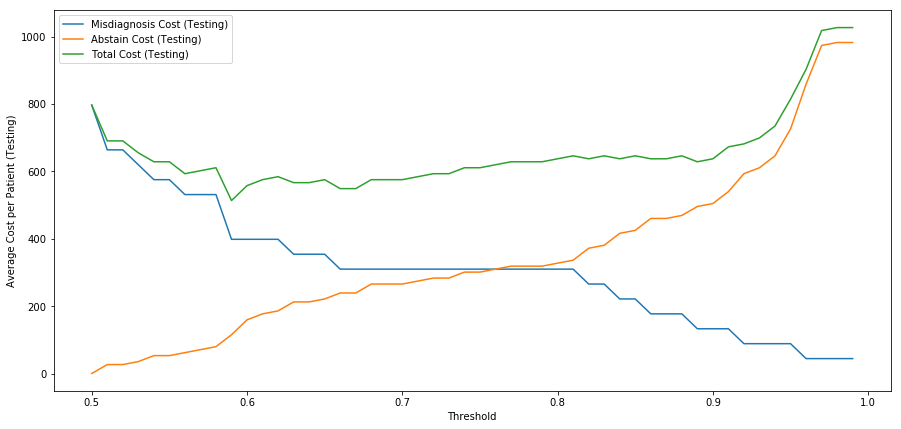

In [126]:
# Just as a visual verification, plot the cost curve for the testing set too
prob_max_test = y_test_prob.max(axis=1)
cost_misdiagnosis_test=[]
cost_abstain_test=[]
for th in thresholds:    
    below_th_ind = np.where(prob_max_test < th)[0]
    above_th_ind = np.where(prob_max_test >= th)[0]
    
    cost_misdiagnosis_test.append((y_test_ovr[above_th_ind] != y_test[above_th_ind]).sum()*5000)
    cost_abstain_test.append(len(below_th_ind)*1000)
    
cost_misdiagnosis_test = np.array(cost_misdiagnosis_test)/len(y_test)
cost_abstain_test = np.array(cost_abstain_test)/len(y_test)
cost_total_test = cost_misdiagnosis_test + cost_abstain_test

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(thresholds, cost_misdiagnosis_test, label='Misdiagnosis Cost (Testing)')
plt.plot(thresholds, cost_abstain_test, label='Abstain Cost (Testing)')
plt.plot(thresholds, cost_total_test, label='Total Cost (Testing)')
plt.xlabel('Threshold')
plt.ylabel('Average Cost per Patient (Testing)')
plt.legend(loc='best')
plt.show()

The shape of the average cost on the testing set agrees with the training set but at a higher level. This is expected as the model is fit to the training dataset.